# Suggestion Forums - Subtask A  


In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.models import Sequential

In [2]:
fileName = 'embedings/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec'

In [3]:
#читаем fasftext -векторная модель значений слов
from numpy import asarray
embeddings_index = dict()
f = open(fileName,encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [4]:
#удалить лишнее
temp = ([ key for key, value in embeddings_index.items() if len(value) == 1])
for t in temp:
    embeddings_index.pop(t)

In [5]:
#чтение тренировочных данных
data=pd.read_csv("Subtask-A-master-Data/Full_V1.3_Training.csv", header=None)

In [6]:
data.head()

,0,1,2
0,663_3,"""Please enable removing language code from the...",1
1,663_4,"""Note: in your .csproj file, there is a Suppor...",0
2,664_1,"""Wich means the new version not fully replaced...",0
3,664_2,"""Some of my users will still receive the old x...",0
4,664_3,"""The store randomly gives the old xap or the n...",0


In [7]:
# предложения
sentences=data.iloc[:,1]

In [8]:
sentences.head()

0    "Please enable removing language code from the...
1    "Note: in your .csproj file, there is a Suppor...
2    "Wich means the new version not fully replaced...
3    "Some of my users will still receive the old x...
4    "The store randomly gives the old xap or the n...
Name: 1, dtype: object

In [9]:
#метки класса
y=data.iloc[:,2]

In [10]:
#статистика, которая понадобится для инициализации embedding_matrix
#all_embs = np.stack(embeddings_index.values())
#emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [12]:
MAX_NB_WORDS = 20000 #максимальное количество рассматриваемых слов
EMBEDDING_DIM = 300 #размер вектора слова
VALIDATION_SPLIT = 0.2 # процент данных, отложенных на валидацию

In [13]:
#предобработка текста, разбиение предложений на последовательности целых чисел
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 9608


In [14]:
#вычисление максимальной длины предложения
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH=int(np.mean([len(sent) for sent in sentences]))
print(MAX_SEQUENCE_LENGTH)
pad_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

109


In [15]:
# разбиение выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size=VALIDATION_SPLIT, random_state=11)

In [16]:
## не больше 20000 слов (хотя их 9609)
nb_words = min(MAX_NB_WORDS, len(word_index)+1) 
print(nb_words)

9609


In [17]:
# create a weight matrix for words
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(9609, 300)

In [18]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,  Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import TimeDistributed

In [25]:
from numpy.random import seed
seed(11)
import tensorflow as tf
tf.random.set_seed(2)

In [50]:
#создание модели
tf.keras.backend.clear_session()
model = keras.Sequential([
keras.layers.InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,)),
keras.layers.Embedding(nb_words,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,trainable=True),
keras.layers.BatchNormalization(),
keras.layers.Dense(EMBEDDING_DIM, activation='relu'),
keras.layers.GlobalMaxPool1D(),    
keras.layers.Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 109, 300)          2882700   
_________________________________________________________________
batch_normalization (BatchNo (None, 109, 300)          1200      
_________________________________________________________________
dense (Dense)                (None, 109, 300)          90300     
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 2,974,501
Trainable params: 2,973,901
Non-trainable params: 600
_________________________________________________________________


In [54]:
model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'], )

In [28]:
print(X_train.shape)

(6442, 109)


In [55]:
#обучение
from tensorflow.keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint('model_simple.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit([X_train], np.asarray(y_train), batch_size=16,  validation_data=(X_test,  np.asarray(y_test)), epochs =5 )

Train on 6442 samples, validate on 1611 samples
Epoch 1/5
6442/6442 [==============================] - 772s 120ms/sample - loss: 0.5439 - accuracy: 0.8195 - val_loss: 0.3547 - val_accuracy: 0.8585
Epoch 2/5
6442/6442 [==============================] - 105s 16ms/sample - loss: 0.1370 - accuracy: 0.9522 - val_loss: 0.4388 - val_accuracy: 0.8647
Epoch 3/5
6442/6442 [==============================] - 126s 20ms/sample - loss: 0.0714 - accuracy: 0.9806 - val_loss: 0.4801 - val_accuracy: 0.8653
Epoch 4/5
6442/6442 [==============================] - 136s 21ms/sample - loss: 0.0659 - accuracy: 0.9840 - val_loss: 0.5914 - val_accuracy: 0.8287
Epoch 5/5
6442/6442 [==============================] - 149s 23ms/sample - loss: 0.0648 - accuracy: 0.9862 - val_loss: 0.5014 - val_accuracy: 0.8703


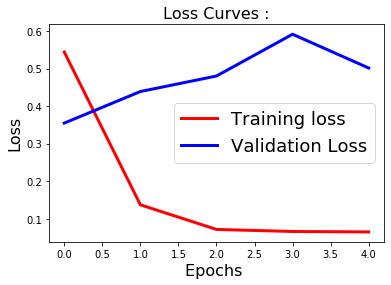

In [56]:
#кривые ошибок Training loss', 'Validation Loss
import matplotlib.pyplot as plt
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :',fontsize=16)
plt.show()

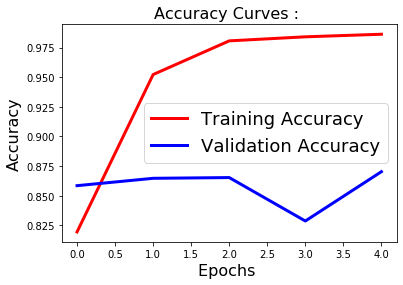

In [59]:
#кривые оценок 'Training Accuracy', 'Validation Accuracy'
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : ',fontsize=16)
plt.show()

In [25]:
#чтение тестовых данных
test_data=pd.read_csv("Subtask-A-master-Data/TrialData_SubtaskA_Test_predictions.csv", header=None)

In [26]:
test_data.head()

,0,1,2
0,13101,"""I'm not asking Microsoft to Gives permission ...",1
1,13121,"""somewhere between Android and iPhone.""",0
2,13131,"""And in the Windows Store you can flag the App...",1
3,13132,"""Many thanks Sameh Hi, As we know, there is a ...",1
4,13133,"""The idea is that we can develop a regular app...",1


In [27]:
#наилучшие веса при обучении
model.load_weights('model_cnnlstm.hdf5', by_name=False)

In [28]:
#предобработка тестовых данных
test_sentences=test_data.iloc[:,1]
test_y=test_data.iloc[:,2]
test_sequences=tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
#пока просмотрим прогноз на валидационных данных
testX_cls=model.predict_classes(X_test)

In [30]:
from sklearn.metrics import f1_score
f1_score(y_test,testX_cls)

0.7605985037406483

In [31]:
#прогноз на тестовых данных
test_cls=model.predict_classes(test_sequences)

In [32]:
f1_score(test_y,test_cls)

0.6767537826685006

In [33]:
#сохранение прогноза
newdata=test_data
newdata.iloc[:,2]=test_cls
newdata.to_csv("submission_cnnlstm.csv", index=False, header=None)